In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import logging
import os

import pandas as pd

import core.config as cconfig
import core.signal_processing as csigproc
import core.statistics as costatis
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint

/app/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-2ee78aa0-2077-4a22-b886-d7010a5a1e9a.json'
INFO  # Git
  branch_name='CMTask8171_add_vol_bps_to_linear_regression_notebook'
  hash='564ff2d7a'
  # Last commits:
    * 564ff2d7a Toma Jordania CmTask8033: update scheduled trading doc (#8255)                  (   4 hours ago) Fri May 10 11:30:00 2024  (HEAD -> CMTask8171_add_vol_bps_to_linear_regression_notebook, origin/master, origin/HEAD, origin/CMTask8171_add_vol_bps_to_linear_regression_notebook, master)
    * 3619a215f Juraj Smeriga CmampTask8090_Document_current_infra_state (#8152)                (   7 hours ago) Fri May 10 08:33:25 2024           
    * a71e048e7 Toma Jordania CmTask8230: propagate save_plots_for_investors t (#8232)          (  10 hours ago) Fri May 10 05:48:45 2024           
# Machine info
  system=Linux
  node name=ba391fd7a4a1
  release=5.15.0-1058-aws
  version=#64~20.04.1-Ubuntu SMP Tue Apr 9 11:1

# Build config

In [4]:
amp_dir = hgit.get_amp_abs_path()
dir_name = os.path.join(
    amp_dir,
    "/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.60T.2023-08-01_2024-01-31.ins.run0/tiled_results",
)
cols = [
    "p1.c",
    "p2.c",
    "p_lr.c",
    "q1.c",
    "q2.c",
    "q3.c",
    "r1.c",
    "r2.c",
    "r4.c",
    "r5.c",
    "r6.c",
    "r_lr.c",
    "v_ld.c",
]

config = {
    "dir_name": dir_name,
    "asset_id_col": "asset_id",
    "feature_col_names": cols,
    "price_col_name": "close",
    "regression_config": {
        "x_cols": cols,
        "x_col_shift": 1,
    },
}
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.60T.2023-08-01_2024-01-31.ins.run0/tiled_results
asset_id_col: asset_id
feature_col_names: ['p1.c', 'p2.c', 'p_lr.c', 'q1.c', 'q2.c', 'q3.c', 'r1.c', 'r2.c', 'r4.c', 'r5.c', 'r6.c', 'r_lr.c', 'v_ld.c']
price_col_name: close
regression_config: 
  x_cols: ['p1.c', 'p2.c', 'p_lr.c', 'q1.c', 'q2.c', 'q3.c', 'r1.c', 'r2.c', 'r4.c', 'r5.c', 'r6.c', 'r_lr.c', 'v_ld.c']
  x_col_shift: 1


# Report tile metadata

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1020313424,2,6,6,3.3 MB
1106736216,2,6,6,3.3 MB
1669260535,2,6,6,3.3 MB
1670436375,2,6,6,3.3 MB
1775391824,2,6,6,3.3 MB
1813442534,2,6,6,3.3 MB
1871387621,2,6,6,3.2 MB
2200033667,2,6,6,3.3 MB
2237530510,2,6,6,3.2 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids     size
year month                      
2023 8               25  13.8 MB
     9               25  13.4 MB
     10              25  13.8 MB
     11              25  13.3 MB
     12              25  13.8 MB
2024 1               25  13.7 MB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1020313424,
 1106736216,
 1669260535,
 1670436375,
 1775391824,
 1813442534,
 1871387621,
 2200033667,
 2237530510,
 2470395105,
 2499295598,
 2506553600,
 2565005155,
 2601760471,
 2971863517,
 2989693852,
 3304664847,
 3323452427,
 3326458212,
 4417972573,
 5141755262,
 6009830573,
 6335759645,
 8717633868,
 8968126878]

# Load features

In [9]:
asset_batch_size = len(asset_ids)
# Add the `asset_id_col` to also display the instruments. This is also required
# to make `yield_parquet_tiles_by_assets()` work.
requested_columns = [config["asset_id_col"]] + config["feature_col_names"]
tile_iter = hparque.yield_parquet_tiles_by_assets(
    config["dir_name"], asset_ids, config["asset_id_col"], asset_batch_size, None
)

In [10]:
tile = next(tile_iter)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
feature_df = dtfmod.process_parquet_read_df(
    tile[config["feature_col_names"] + [config["asset_id_col"]]],
    config["asset_id_col"],
)

# Generate target

In [12]:
asset_batch_size = len(asset_ids)
# Add the `asset_id_col` to also display the instruments. This is also required
# to make `yield_parquet_tiles_by_assets()` work.
requested_columns = [config["asset_id_col"]] + [config["price_col_name"]]
tile_iter = hparque.yield_parquet_tiles_by_assets(
    config["dir_name"], asset_ids, config["asset_id_col"], asset_batch_size, None
)

In [13]:
tile = next(tile_iter)

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
price_df = dtfmod.process_parquet_read_df(
    tile[[config["price_col_name"]] + [config["asset_id_col"]]],
    config["asset_id_col"],
)

In [15]:
rets_df = price_df.pct_change()
rets_df = rets_df.rename(mapper={"close": "rets"}, axis=1, level=0)
vol_df = rets_df.rolling(30).std()
zrets_df = csigproc.compress_tails(
    rets_df / vol_df.shift(config["regression_config"]["x_col_shift"]), 4
)
zrets_df = zrets_df.rename(mapper={"rets": "zrets"}, axis=1, level=0)

array([[<Axes: title={'center': 'zrets'}>]], dtype=object)

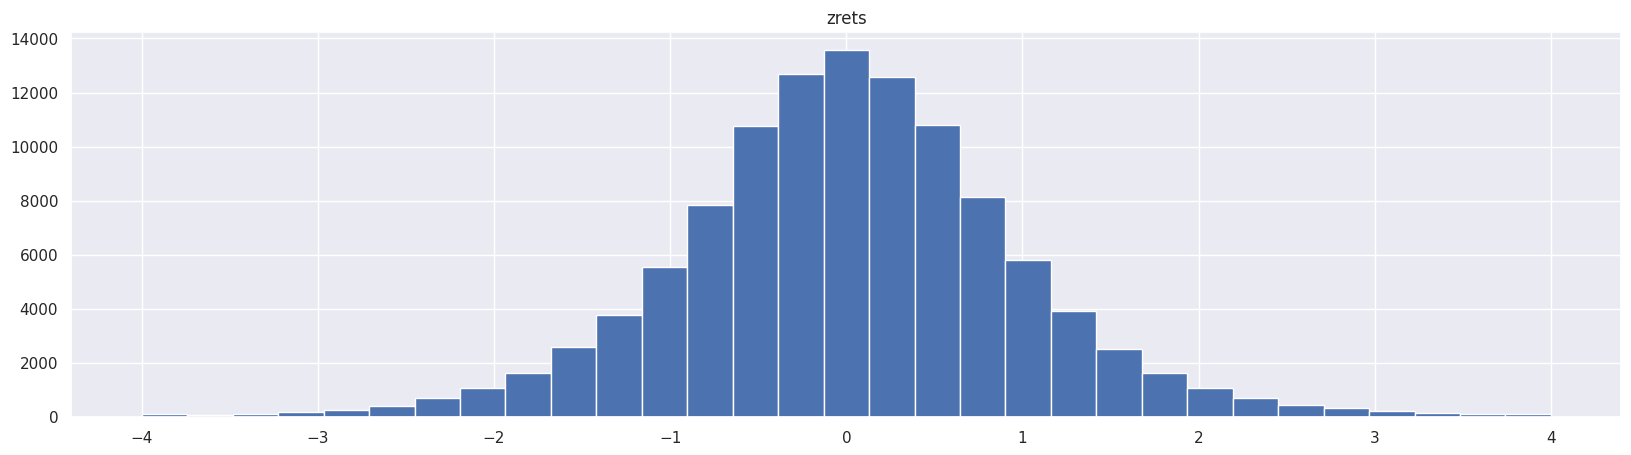

In [16]:
zrets_df.stack().hist(bins=31)

In [27]:
# Approximate total volatility in bps.
1e4 * vol_df.mean().mean()

93.21382094459739

In [18]:
# Approximate total vol in bps by asset.
1e4 * vol_df.mean()

      asset_id  
rets  1020313424     93.671944
      1106736216     95.333454
      1669260535    100.485251
      1670436375     96.798958
      1775391824    100.468553
      1813442534     81.865321
      1871387621     69.042301
      2200033667    161.641840
      2237530510     94.821538
      2470395105     47.215165
      2499295598     98.705587
      2506553600    106.170354
      2565005155    106.290108
      2601760471     79.943809
      2971863517    112.971553
      2989693852    105.451052
      3304664847     67.405211
      3323452427     63.452939
      3326458212    108.721338
      4417972573     93.499866
      5141755262     86.988835
      6009830573    131.405226
      6335759645     93.720530
      8717633868     89.277714
      8968126878     44.997074
dtype: float64

# Combine features and target

In [19]:
regression_df = pd.concat([feature_df, zrets_df], axis=1)

In [20]:
regression_df.columns.levels[0]

Index(['p1.c', 'p2.c', 'p_lr.c', 'q1.c', 'q2.c', 'q3.c', 'r1.c', 'r2.c', 'r4.c', 'r5.c', 'r6.c', 'r_lr.c', 'v_ld.c', 'zrets'], dtype='object')

In [21]:
regression_coeffs = costatis.compute_regression_coefficients_by_group(
    regression_df,
    y_col="zrets",
    **config["regression_config"].to_dict(),
)
display(regression_coeffs.head())

Processing groups:   0%|          | 0/25 [00:00<?, ?it/s]

count  eff_count      mean       var     covar   sgn_rho       rho      beta  SE(beta)  beta_z_scored  p_val_2s  autocovar  autocorr      turn
1020313424 p1.c     4384     4384.0 -0.262329  1.873398 -0.017819 -0.030794 -0.013458 -0.009512  0.010674      -0.891062  0.372896   0.440061  0.234900  1.237012
           p2.c     4384     4384.0 -0.030376  1.098059 -0.016928 -0.046761 -0.016700 -0.015417  0.013943      -1.105719  0.268848  -0.041967 -0.038220  1.440985
           p_lr.c   4384     4384.0 -0.148417  1.597772 -0.022956 -0.043568 -0.018773 -0.014367  0.011558      -1.243011  0.213864   0.146245  0.091531  1.347939
           q1.c     4384     4384.0  0.311783  0.267272 -0.002150 -0.011633 -0.004299 -0.008043  0.028261      -0.284614  0.775940   0.110988  0.415264  1.081421
           q2.c     4384     4384.0 -0.098841  0.232760 -0.009387 -0.038093 -0.020112 -0.040328  0.030283      -1.331680  0.182965   0.049502  0.212675  1.254850

In [22]:
regression_coeffs.groupby(level=1).mean()

,count,eff_count,mean,var,covar,sgn_rho,rho,beta,SE(beta),beta_z_scored,p_val_2s,autocovar,autocorr,turn
p1.c,4384.0,4384.0,-0.279506,2.031466,-0.020864,-0.032546,-0.015309,-0.010539,0.010285,-1.013614,0.305163,0.417100,0.204678,1.261002
p2.c,4384.0,4384.0,-0.033024,1.099174,-0.023126,-0.042582,-0.022577,-0.020723,0.014005,-1.494894,0.211594,-0.039444,-0.036239,1.439580
p_lr.c,4384.0,4384.0,-0.159465,1.699029,-0.030128,-0.050283,-0.023839,-0.017699,0.011232,-1.578424,0.163482,0.111172,0.065459,1.367033
q1.c,4384.0,4384.0,0.379509,0.343084,0.006741,0.003978,0.011901,0.019870,0.025247,0.788018,0.409402,0.156812,0.452385,1.045668
q2.c,4384.0,4384.0,-0.101324,0.282177,-0.009333,-0.036068,-0.018488,-0.034500,0.027741,-1.224141,0.209567,0.044917,0.160457,1.295503
q3.c,4384.0,4384.0,-0.021373,0.156056,-0.006324,-0.035465,-0.015966,-0.038342,0.037774,-1.057165,0.314957,0.005239,0.034843,1.389280
r1.c,4384.0,4384.0,-0.134404,0.584032,-0.008514,-0.026907,-0.011561,-0.014805,0.019304,-0.765442,0.393332,0.052700,0.091370,1.347973
r2.c,4384.0,4384.0,-0.056322,2.278028,-0.036604,-0.046980,-0.024939,-0.015949,0.009712,-1.651267,0.178109,-0.027803,-0.012355,1.422888
r4.c,4384.0,4384.0,-0.213307,2.824398,-0.016795,-0.022144,-0.010167,-0.005792,0.008747,-0.673175,0.358986,0.470941,0.165903,1.291424
r5.c,4384.0,4384.0,0.036150,0.905852,0.014147,0.029954,0.015803,0.016727,0.015758,1.046352,0.339908,0.036226,0.042656,1.383666


In [23]:
q_vals = costatis.estimate_q_values(regression_coeffs["p_val_2s"])
regression_coeffs["q_val"] = q_vals

INFO  pi0=0.280 (estimated proportion of null features)


In [24]:
q_val_df = []
for feature in config["feature_col_names"]:
    q_val_srs = (
        regression_coeffs["q_val"]
        .xs(feature, level=1)
        .sort_values()
        .reset_index()["q_val"]
    )
    q_val_srs.name = feature
    q_val_df.append(q_val_srs)
q_val_df = pd.concat(q_val_df, axis=1)

<Axes: >

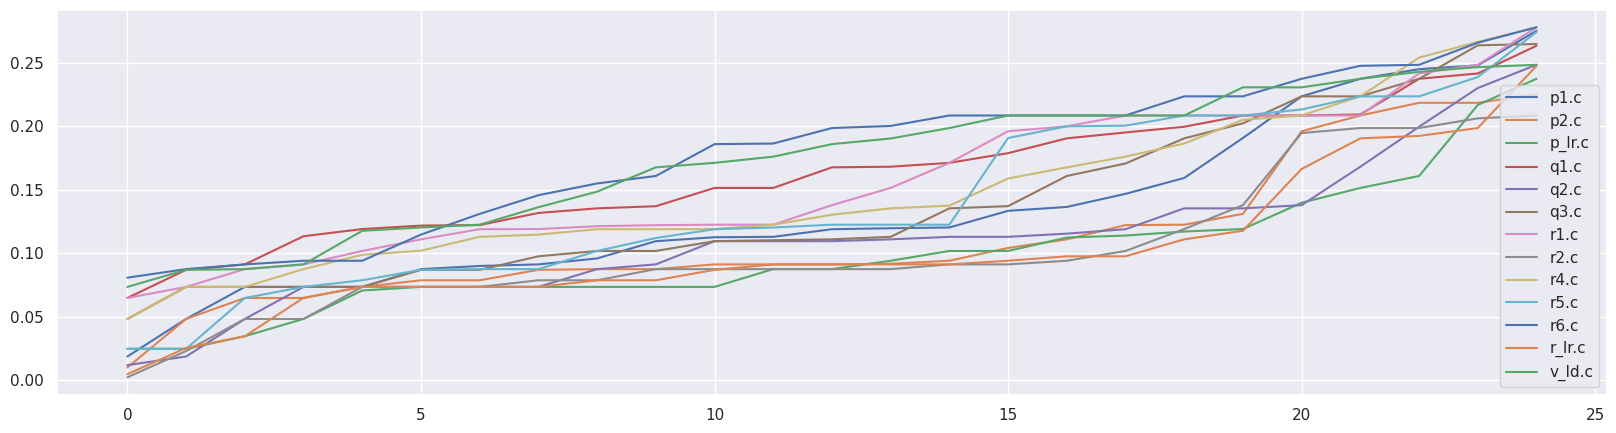

In [25]:
q_val_df.plot()